** Assignment 7**
=================
Name : Nihar Kanungo Batch : 6:30 AM , Monday

Background :
==========
This is a Image Recognition program which makes use of the Cifar 10 preprocessed dataset . The Code uses one of the most popular Tensorflow API Keras to perform the operations .It's a supervised Computer Vision problem.  There are so many state of the Art models developed over the period of time. Every year new models win the Imagenet competition being better than the previous year's winner. While the approaches adopted by those networks share many of the similar concepts at the same time the architecture design was seen to have gone through a lot of change . Having said that the best Architecture model till date has found to be ENAS (Efficient Neural Architecture Search). This model was developed by a machine learning algorithm and it contains the direct and many skip connections from many previous layers . 

ENAS is a fast and inexpensive approach for automatic model design. ENAS constructs a large computational graph, where each subgraph represents a neural network architecture, hence forcing all architectures to share their parameters. A controller is trained with policy gradient to search for a subgraph that maximizes the expected reward on a validation set. Meanwhile a model corresponding to the selected subgraph is trained to minimize a canonical cross entropy loss. Sharing parameters among child models allows ENAS to deliver strong empirical performances, whilst using much fewer GPU-hours than existing automatic model design approaches, and notably, 1000x less expensive than standard Neural Architecture Search.


Input
=======

1) 60000 images (10 Class)

2) The Images are already segreegated as Train and Test Data with the respective target values

Environment

Development - Colab GPU , Jupyter Notebook Repository : Github

Algorithm
===========
Functional API Model 

Convolutional Neural Network (2D)

Maxpooling 

Softmax Activation function 

loss Function : Categorical Crossentropy 

Optimizer=Adam, SGD 

Metrics=accuracy 

Batch Normalization 

Drop Out 

Image Normalization 

L2 Regularization

Parameters
===========

Batch Size - Variable 

Epochs - Variable 

Kernel Size - Variable 

Number of Kernels - Variable 

Learning Rate regularization coefficient

Conditions
==========
The Model should train (> 20% accuracy ). As this program is meant to show the usage of functional API and not to accurately predict the classes .

# Import all Libraries 

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Input, concatenate
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras.models import Model
import tensorflow as tf
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda


Using TensorFlow backend.


* Load the CIFAR 10 images into the notebook 
===========================================

The **CIFAR-10 dataset** (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. 
Computer algorithms for recognizing objects in photos often learn by example. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.
CIFAR-10 is a labeled subset of the 80 million tiny images dataset. When the dataset was created, students were paid to label all of the images. 

Source : wikipedia

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 12s 0us/step


Display the Class outputs
===========================

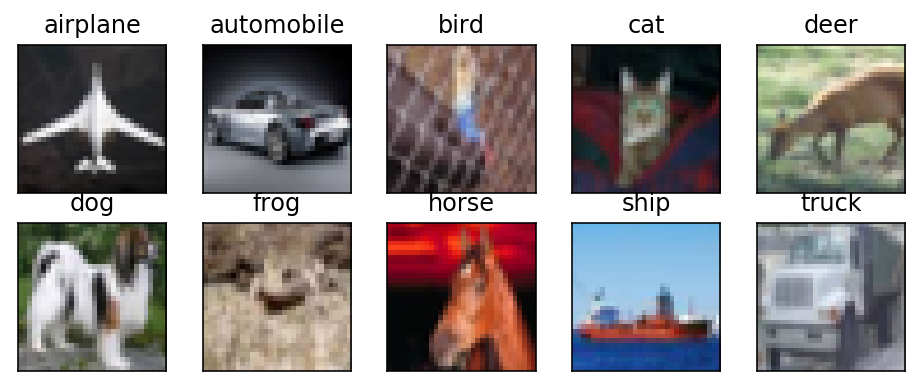

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Function to define the Model history and Plot chart
=====================================================
The Parameters of the model is a key information to quickly visualize how the model performed . Analysis of the

1. Training Accuracy vs Validation Accuracy and

2. Training Loss vs Validation Loss

would give a great understanding of the model performance

Writting a custom function helps us to modify or customize the information based on our need. We are building these functions so that we can customize more in future

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Function to define the Accuracy of the model

This custom function will help us i future to design the Accuracy based on our need

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Standardize the data by diving it by 255
==========================================

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Each of the above discussed convolution methods has been designed as functions below . We may use multiple such layers in our network.


Normal convolution
===================

This convolution is the one which we have been doing so far

![](images/nc.png)

In [0]:

def norm_conv_layer(inputs, n_kernels=32, kernel_size=(3,3), dropout=0.1,dilation_rate=1, border_mode='valid',stride=1):
  conv_out = Conv2D(n_kernels,
                kernel_size=kernel_size,
                strides=stride,
                border_mode=border_mode,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate)(inputs)
  conv_out = BatchNormalization()(conv_out)
  conv_out = Activation("relu")(conv_out)
  conv_out = Dropout(dropout)(conv_out)
  return conv_out







Depthwise Separable Convolution
=======================

Depthwise convolution deals with number of channels .Every channel will have different interpretations . Fir example if a layer of the network has 64 channels then there would be 64 different interpretation for it . All these can work in parallel. The diagram below explains it.

![](images/ds.png)

In [0]:
def depthwise_conv_layer(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.1,dilation_rate=1, border_mode='valid', depth_multiplier=1,):
  dep_conv_out = SeparableConv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                border_mode=border_mode,
                kernel_regularizer=l2(1e-4),
                dilation_rate=dilation_rate,
                depth_multiplier=depth_multiplier,)(inputs)
  dep_conv_out = BatchNormalization()(dep_conv_out)
  dep_conv_out = Activation("relu")(dep_conv_out)
  dep_conv_out = Dropout(dropout)(dep_conv_out)
  return dep_conv_out

Transition Layer
==================

1 x 1 convolution 

In [0]:
def trans_layer(inputs, n_kernels=32,dropout=0):
  trans_out = norm_conv_layer(inputs, n_kernels, kernel_size=(1,1),dropout=dropout, border_mode='same')
  return trans_out


# Output function 

1. Flatten

2. Softmax layer

In [0]:
def output_layer(inputs, n_classes, kernel_size):
  final_out = Conv2D(n_classes,
                kernel_size=kernel_size,
                strides=1,
                border_mode='valid',
                kernel_regularizer=l2(1e-4),
                dilation_rate=1)(inputs)
  final_out = Flatten()(final_out)
  out = Activation("softmax")(final_out)
  return out



#Functional API model

This Assignment is to create the ENAS model manually using the Keras API. The following table shows the different connections (direct and skip) for each layer . 

![](images/enas.png)
![](images/model.png)

The intention behind deploying the ENAs model manually is to have a hands on Functional API, Skip Connection and space to depth methodology.


Model Architecture 
=====================


After Every convolution there are Batch Normalization and Dropouts specified to ensure that the models don't over train 
L2 Regularizer is also added to ensure the model not being over trained 


      


In [0]:

inputs = Input(shape=(32,32,3))

x1 = depthwise_conv_layer(inputs, n_kernels=64,kernel_size=(5,5),border_mode='valid')

x2 = norm_conv_layer(x1,n_kernels=64,kernel_size=(5,5),border_mode='same')  # 9

x3 = norm_conv_layer(x2,n_kernels=64,kernel_size=(5,5),border_mode='same')  #13

x4 = concatenate([x1, x3]) # 9,17
x4 = depthwise_conv_layer(x4, n_kernels=64,kernel_size=(5,5),border_mode='same')

x5 = MaxPooling2D(pool_size=(2, 2),)(x4)
x6 = depthwise_conv_layer(x5, n_kernels=64,kernel_size=(3,3),border_mode='same') 

x7_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x7_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x7 = concatenate([x6, x7_1, x7_2])
x7 = norm_conv_layer(x7, n_kernels=64,kernel_size=(5,5),border_mode='same')


x8_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x8_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x8 = concatenate([x6, x7,x8_1,x8_2])
x8 = depthwise_conv_layer(x8, n_kernels=64,kernel_size=(3,3),border_mode='same')


x9_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x9_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x9_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x9 = concatenate([x6,x7,x8,x9_1, x9_2,x9_3])
x9 = depthwise_conv_layer(x9, n_kernels=64,kernel_size=(3,3),border_mode='same')

x10_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x10 = concatenate([x6,x8,x9,x10_1])
x10 = MaxPooling2D(pool_size=(2, 2),)(x10)


#x11_1 = norm_conv_layer(x10, n_kernels=64,kernel_size=(5,5),border_mode='same')
x11_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x7)
x11 = concatenate([x10, x11_1])
x11 = norm_conv_layer(x11, n_kernels=64,kernel_size=(5,5),border_mode='same')


x12_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x12_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x12_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x12 = concatenate([x11, x12_1, x12_2,x12_3])
x12 = depthwise_conv_layer(x12, n_kernels=64,kernel_size=(5,5),border_mode='same')


x13_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x13_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x13_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x13 = concatenate([x11,x12,x13_1, x13_2,x13_3])
x13 = norm_conv_layer(x13, n_kernels=64,kernel_size=(3,3),border_mode='same')

x14_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x14_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x14_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x1)
x14_4 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x14_5 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x14 = concatenate([x12,x13,x14_1, x14_2,x14_3, x14_4, x14_5])
x14 = depthwise_conv_layer(x14, n_kernels=64,kernel_size=(5,5),border_mode='same')

x15_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x15_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x15 = concatenate([x12,x14,x15_1, x15_2])
output = output_layer(x15, n_classes=10, kernel_size=(7,7)) # 24, 32

model = Model(inputs=inputs, outputs=output)
optimizer = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])


W0902 13:10:59.484985 139705983539072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 13:10:59.521859 139705983539072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, depth_multiplier=1, padding="valid")`
  
W0902 13:10:59.531479 139705983539072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 13

# Print the summary of the model architecture 

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 28, 28, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# Model Training and Validation

1. Normalize the Images

2. Fit the images to the model

3. Calculate the time taken for training 

4. Plot the model parameters

5. Print the last validation accuracy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 144s 370ms/step - loss: 1.4183 - acc: 0.5158 - val_loss: 1.3510 - val_acc: 0.5326
Epoch 2/50
390/390 [==============================] - 144s 369ms/step - loss: 1.3208 - acc: 0.5501 - val_loss: 1.3078 - val_acc: 0.5525
Epoch 3/50
390/390 [==============================] - 143s 368ms/step - loss: 1.2506 - acc: 0.5776 - val_loss: 1.2957 - val_acc: 0.5603
Epoch 4/50
390/390 [==============================] - 144s 368ms/step - loss: 1.1897 - acc: 0.5990 - val_loss: 1.2821 - val_acc: 0.5714
Epoch 5/50
390/390 [==============================] - 143s 367ms/step - loss: 1.1374 - acc: 0.6195 - val_loss: 1.2263 - val_acc: 0.5883
Epoch 6/50
390/390 [==============================] - 143s 367ms/step - loss: 1.0979 - acc: 0.6342 - val_loss: 1.2541 - val_acc: 0.5752
Epoch 7/50
390/390 [==============================] - 143s 367ms/step - loss: 1.0594 - acc: 0.6487 - val_loss: 1.1613 - val_acc: 0.6106
Epoch 8/50
390/390 [============================

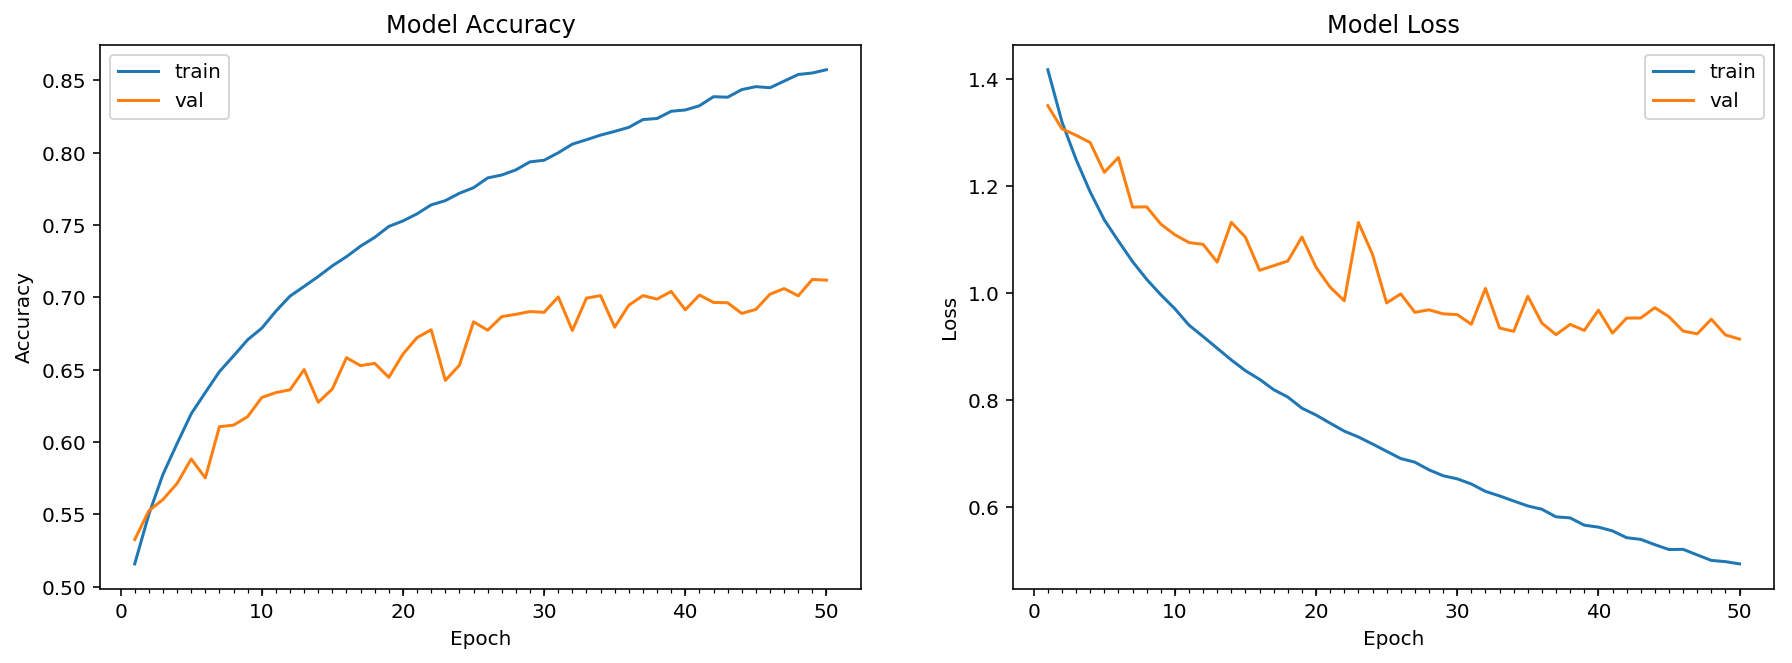

Accuracy on test data is: 71.19


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Observation
===============

If we observe the Accuracy curve then the training and validation curves hardly met each other in any iteration. This shows that the Validation is not smooth . The Possible reasons for this could be the hyper parameters which is not choosen correctly resulting in not converging to the minimum. The possible reason could be 
  1. vanishing gradient or 
  2. improper learning rate or 
  3. momentum
  
The Loss curve is also not smooth for validation loss. The reason could be same . Also i am wondering if L2 regularization is having impact on the model being over trained as at times too much regularization causes the model to perform bad . We will try 

1. removing L2 from the model and 
2. Add transition blocks  to see how it performs .
 

However before we do that I am just trying to run the model with different number of kernels . Let's see what the output looks like.

W0903 12:20:15.644129 140052710381440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 12:20:15.683581 140052710381440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, depth_multiplier=1, padding="valid")`
  
W0903 12:20:15.692169 140052710381440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 12

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 28, 28, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

W0903 12:20:21.468185 140052710381440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
390/390 [==============================] - 241s 618ms/step - loss: 1.8990 - acc: 0.3686 - val_loss: 1.6892 - val_acc: 0.4424
Epoch 2/50
390/390 [==============================] - 227s 582ms/step - loss: 1.6023 - acc: 0.4736 - val_loss: 1.5180 - val_acc: 0.5002
Epoch 3/50
390/390 [==============================] - 227s 582ms/step - loss: 1.4592 - acc: 0.5260 - val_loss: 1.4333 - val_acc: 0.5379
Epoch 4/50
390/390 [==============================] - 226s 580ms/step - loss: 1.3618 - acc: 0.5632 - val_loss: 1.4073 - val_acc: 0.5387
Epoch 5/50
390/390 [==============================] - 226s 580ms/step - loss: 1.2883 - acc: 0.5942 - val_loss: 1.3626 - val_acc: 0.5684
Epoch 6/50
390/390 [==============================] - 226s 580ms/step - loss: 1.2271 - acc: 0.6120 - val_loss: 1.4244 - val_acc: 0.5491
Epoch 7/50
390/390 [==============================] - 227s 582ms/step - loss: 1.1746 - acc: 0.6319 - val_loss: 1.2939 - val_acc: 0.5913
Epoch 8/50
390/390 [============================

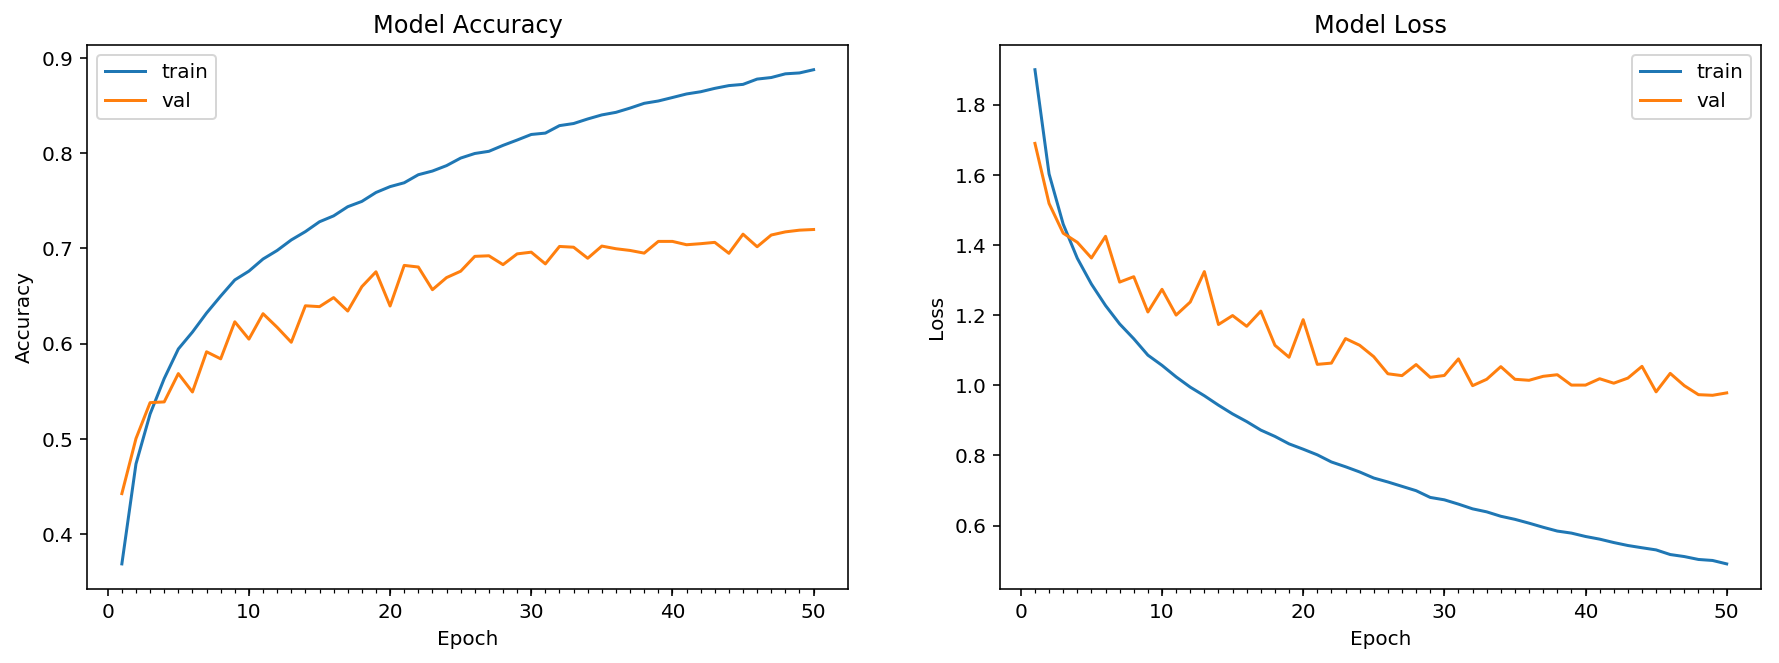

Accuracy on test data is: 71.97


In [11]:
inputs = Input(shape=(32,32,3))

x1 = depthwise_conv_layer(inputs, n_kernels=64,kernel_size=(5,5),border_mode='valid')

x2 = norm_conv_layer(x1,n_kernels=64,kernel_size=(5,5),border_mode='same')  # 9

x3 = norm_conv_layer(x2,n_kernels=64,kernel_size=(5,5),border_mode='same')  #13

x4 = concatenate([x1, x3]) # 9,17
x4 = depthwise_conv_layer(x4, n_kernels=64,kernel_size=(5,5),border_mode='same')

x5 = MaxPooling2D(pool_size=(2, 2),)(x4)
x6 = depthwise_conv_layer(x5, n_kernels=128,kernel_size=(3,3),border_mode='same') 

x7_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x7_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x7 = concatenate([x6, x7_1, x7_2])
x7 = norm_conv_layer(x7, n_kernels=128,kernel_size=(5,5),border_mode='same')


x8_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x8_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x8 = concatenate([x6, x7,x8_1,x8_2])
x8 = depthwise_conv_layer(x8, n_kernels=128,kernel_size=(3,3),border_mode='same')


x9_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x9_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x9_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x9 = concatenate([x6,x7,x8,x9_1, x9_2,x9_3])
x9 = depthwise_conv_layer(x9, n_kernels=128,kernel_size=(5,5),border_mode='same')

x10_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x10 = concatenate([x6,x8,x9,x10_1])
x10 = MaxPooling2D(pool_size=(2, 2),)(x10)


#x11_1 = norm_conv_layer(x10, n_kernels=64,kernel_size=(5,5),border_mode='same')
x11_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x7)
x11 = concatenate([x10, x11_1])
x11 = norm_conv_layer(x11, n_kernels=256,kernel_size=(5,5),border_mode='same')


x12_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x12_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x12_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x12 = concatenate([x11, x12_1, x12_2,x12_3])
x12 = depthwise_conv_layer(x12, n_kernels=256,kernel_size=(5,5),border_mode='same')


x13_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x13_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x13_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x13 = concatenate([x11,x12,x13_1, x13_2,x13_3])
x13 = norm_conv_layer(x13, n_kernels=256,kernel_size=(3,3),border_mode='same')

x14_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x14_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x14_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x1)
x14_4 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x14_5 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x14 = concatenate([x12,x13,x14_1, x14_2,x14_3, x14_4, x14_5])
x14 = depthwise_conv_layer(x14, n_kernels=256,kernel_size=(5,5),border_mode='same')

x15_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x15_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x15 = concatenate([x12,x14,x15_1, x15_2])
output = output_layer(x15, n_classes=10, kernel_size=(7,7)) # 24, 32

model = Model(inputs=inputs, outputs=output)
optimizer = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])


model.summary()

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, depth_multiplier=1, padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, depth_multiplier=1, padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, kernel_size=(3, 3), strides=1, kernel_regularizer=<keras.r

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 28, 28, 64)   331         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 28, 28, 64)   256         separable_conv2d_8[0][0]         
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 28, 28, 64)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
390/390 [==============================] - 225s 578ms/step - loss: 2.2609 - acc: 0.2344 - val_loss: 1.9557 - val_acc: 0.3271
Epoch 2/50
390/390 [==============================] - 221s 566ms/step - loss: 1.9359 - acc: 0.3454 - val_loss: 1.8203 - val_acc: 0.3816
Epoch 3/50
390/390 [==============================] - 221s 567ms/step - loss: 1.7962 - acc: 0.3950 - val_loss: 1.7170 - val_acc: 0.4172
Epoch 4/50
390/390 [==============================] - 221s 567ms/step - loss: 1.7082 - acc: 0.4242 - val_loss: 1.6468 - val_acc: 0.4451
Epoch 5/50
390/390 [==============================] - 221s 566ms/step - loss: 1.6446 - acc: 0.4486 - val_loss: 1.6101 - val_acc: 0.4596
Epoch 6/50
390/390 [==============================] - 222s 568ms/step - loss: 1.5939 - acc: 0.4687 - val_loss: 1.6198 - val_acc: 0.4668
Epoch 7/50
390/390 [==============================] - 221s 566ms/step - loss: 1.5543 - acc: 0.4851 - val_loss: 1.5331 - val_acc: 0.4895
Epoch 8/50
390/390 [============================

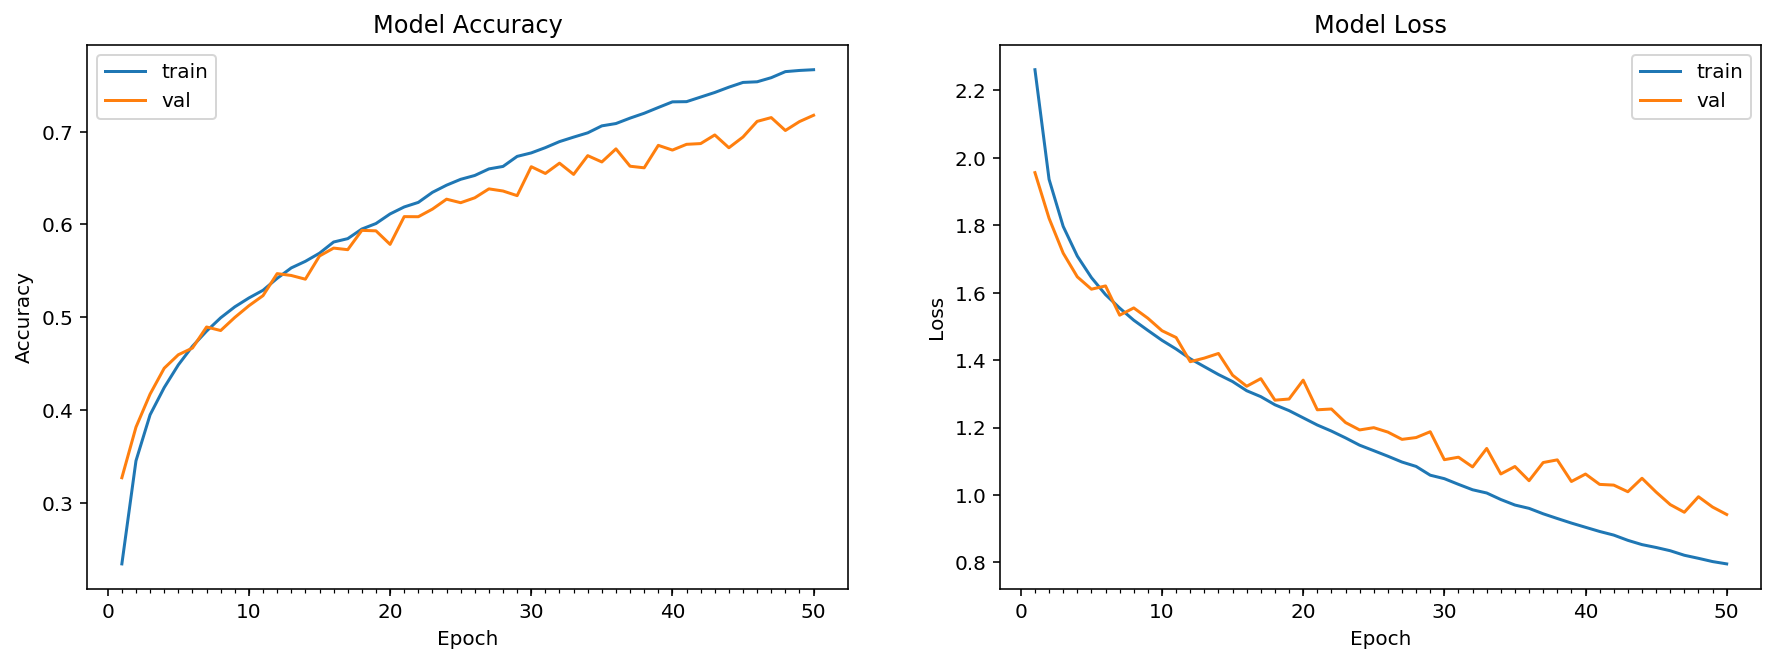

Accuracy on test data is: 71.76


In [12]:
inputs = Input(shape=(32,32,3))

x1 = depthwise_conv_layer(inputs, n_kernels=64,kernel_size=(5,5),border_mode='valid')

x2 = norm_conv_layer(x1,n_kernels=64,kernel_size=(5,5),border_mode='same')  # 9

x3 = norm_conv_layer(x2,n_kernels=64,kernel_size=(5,5),border_mode='same')  #13

x4 = concatenate([x1, x3]) # 9,17
x4 = depthwise_conv_layer(x4, n_kernels=64,kernel_size=(5,5),border_mode='same')

x5 = MaxPooling2D(pool_size=(2, 2),)(x4)
x6 = depthwise_conv_layer(x5, n_kernels=128,kernel_size=(3,3),border_mode='same') 

x7_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x7_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x7 = concatenate([x6, x7_1, x7_2])
x7 = norm_conv_layer(x7, n_kernels=128,kernel_size=(5,5),border_mode='same')


x8_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x8_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x8 = concatenate([x6, x7,x8_1,x8_2])
x8 = depthwise_conv_layer(x8, n_kernels=128,kernel_size=(3,3),border_mode='same')


x9_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x9_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x9_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x9 = concatenate([x6,x7,x8,x9_1, x9_2,x9_3])
x9 = depthwise_conv_layer(x9, n_kernels=128,kernel_size=(5,5),border_mode='same')

x10_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x10 = concatenate([x6,x8,x9,x10_1])
x10 = MaxPooling2D(pool_size=(2, 2),)(x10)


#x11_1 = norm_conv_layer(x10, n_kernels=64,kernel_size=(5,5),border_mode='same')
x11_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x7)
x11 = concatenate([x10, x11_1])
x11 = norm_conv_layer(x11, n_kernels=256,kernel_size=(5,5),border_mode='same')


x12_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x12_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x12_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x12 = concatenate([x11, x12_1, x12_2,x12_3])
x12 = depthwise_conv_layer(x12, n_kernels=256,kernel_size=(5,5),border_mode='same')


x13_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x13_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x13_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x13 = concatenate([x11,x12,x13_1, x13_2,x13_3])
x13 = norm_conv_layer(x13, n_kernels=256,kernel_size=(3,3),border_mode='same')

x14_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x14_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x14_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x1)
x14_4 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x14_5 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x14 = concatenate([x12,x13,x14_1, x14_2,x14_3, x14_4, x14_5])
x14 = depthwise_conv_layer(x14, n_kernels=256,kernel_size=(5,5),border_mode='same')

x15_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x15_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x15 = concatenate([x12,x14,x15_1, x15_2])
x15 = norm_conv_layer(x15,n_kernels=32,kernel_size=(1,1),border_mode='same')  # 9

output = output_layer(x15, n_classes=10, kernel_size=(7,7)) # 24, 32

model = Model(inputs=inputs, outputs=output)
optimizer = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])


model.summary()

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
inputs = Input(shape=(32,32,3))

x1 = depthwise_conv_layer(inputs, n_kernels=64,kernel_size=(5,5),border_mode='valid')

x2 = norm_conv_layer(x1,n_kernels=64,kernel_size=(5,5),border_mode='same')  # 9

x3 = norm_conv_layer(x2,n_kernels=64,kernel_size=(5,5),border_mode='same')  #13

x4 = concatenate([x1, x3]) # 9,17
x4 = depthwise_conv_layer(x4, n_kernels=64,kernel_size=(5,5),border_mode='same')

x5 = MaxPooling2D(pool_size=(2, 2),)(x4)
x5 = norm_conv_layer(x5,n_kernels=32,kernel_size=(1,1),border_mode='same')

x6 = depthwise_conv_layer(x5, n_kernels=128,kernel_size=(3,3),border_mode='same') 

x7_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x7_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x7 = concatenate([x6, x7_1, x7_2])
x7 = norm_conv_layer(x7, n_kernels=128,kernel_size=(5,5),border_mode='same')


x8_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x8_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x8 = concatenate([x6, x7,x8_1,x8_2])
x8 = depthwise_conv_layer(x8, n_kernels=128,kernel_size=(3,3),border_mode='same')


x9_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x9_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x9_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x9 = concatenate([x6,x7,x8,x9_1, x9_2,x9_3])
x9 = depthwise_conv_layer(x9, n_kernels=128,kernel_size=(5,5),border_mode='same')

x10_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x10 = concatenate([x6,x8,x9,x10_1])
x10 = MaxPooling2D(pool_size=(2, 2),)(x10)
x10 = norm_conv_layer(x10,n_kernels=32,kernel_size=(1,1),border_mode='same')

#x11_1 = norm_conv_layer(x10, n_kernels=64,kernel_size=(5,5),border_mode='same')
x11_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x7)
x11 = concatenate([x10, x11_1])
x11 = norm_conv_layer(x11, n_kernels=256,kernel_size=(5,5),border_mode='same')


x12_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x12_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x12_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x12 = concatenate([x11, x12_1, x12_2,x12_3])
x12 = depthwise_conv_layer(x12, n_kernels=256,kernel_size=(5,5),border_mode='same')


x13_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x13_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x13_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x13 = concatenate([x11,x12,x13_1, x13_2,x13_3])
x13 = norm_conv_layer(x13, n_kernels=256,kernel_size=(3,3),border_mode='same')

x14_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x14_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x14_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x1)
x14_4 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x14_5 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x14 = concatenate([x12,x13,x14_1, x14_2,x14_3, x14_4, x14_5])
x14 = depthwise_conv_layer(x14, n_kernels=256,kernel_size=(5,5),border_mode='same')

x15_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x15_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x15 = concatenate([x12,x14,x15_1, x15_2])
x15 = norm_conv_layer(x15,n_kernels=32,kernel_size=(1,1),border_mode='same')  # 9

output = output_layer(x15, n_classes=10, kernel_size=(7,7)) # 24, 32

model = Model(inputs=inputs, outputs=output)
optimizer = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])


model.summary()

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

W0904 02:50:49.489091 139890681915264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 02:50:49.539169 139890681915264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, depth_multiplier=1, padding="valid")`
  
W0904 02:50:49.554982 139890681915264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 02

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 28, 28, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

W0904 02:50:56.227114 139890681915264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
390/390 [==============================] - 234s 599ms/step - loss: 2.2367 - acc: 0.2410 - val_loss: 1.9229 - val_acc: 0.3494
Epoch 2/100
390/390 [==============================] - 219s 561ms/step - loss: 1.9276 - acc: 0.3471 - val_loss: 1.8035 - val_acc: 0.3955
Epoch 3/100
390/390 [==============================] - 219s 561ms/step - loss: 1.8107 - acc: 0.3912 - val_loss: 1.7372 - val_acc: 0.4225
Epoch 4/100
390/390 [==============================] - 219s 561ms/step - loss: 1.7319 - acc: 0.4191 - val_loss: 1.6540 - val_acc: 0.4508
Epoch 5/100
390/390 [==============================] - 219s 562ms/step - loss: 1.6710 - acc: 0.4417 - val_loss: 1.6142 - val_acc: 0.4662
Epoch 6/100
390/390 [==============================] - 220s 564ms/step - loss: 1.6165 - acc: 0.4634 - val_loss: 1.5723 - val_acc: 0.4805
Epoch 7/100
390/390 [==============================] - 219s 562ms/step - loss: 1.5678 - acc: 0.4810 - val_loss: 1.5580 - val_acc: 0.4907
Epoch 8/100
390/390 [====================

W0904 12:34:07.856184 140314241509248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 12:34:07.898907 140314241509248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, depth_multiplier=1, padding="valid")`
  
W0904 12:34:07.911858 140314241509248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 12

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 28, 28, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

W0904 12:34:14.670409 140314241509248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
390/390 [==============================] - 235s 602ms/step - loss: 1.7822 - acc: 0.4025 - val_loss: 1.5347 - val_acc: 0.4939
Epoch 2/30
390/390 [==============================] - 221s 566ms/step - loss: 1.4367 - acc: 0.5311 - val_loss: 1.3471 - val_acc: 0.5621
Epoch 3/30
390/390 [==============================] - 221s 566ms/step - loss: 1.2658 - acc: 0.5968 - val_loss: 1.2113 - val_acc: 0.6176
Epoch 4/30
390/390 [==============================] - 221s 567ms/step - loss: 1.1416 - acc: 0.6428 - val_loss: 1.1886 - val_acc: 0.6286
Epoch 5/30
390/390 [==============================] - 221s 566ms/step - loss: 1.0505 - acc: 0.6779 - val_loss: 1.3626 - val_acc: 0.5782
Epoch 6/30
390/390 [==============================] - 220s 565ms/step - loss: 0.9735 - acc: 0.7047 - val_loss: 1.0644 - val_acc: 0.6744
Epoch 7/30
390/390 [==============================] - 220s 565ms/step - loss: 0.9111 - acc: 0.7270 - val_loss: 1.2466 - val_acc: 0.6276
Epoch 8/30
390/390 [============================

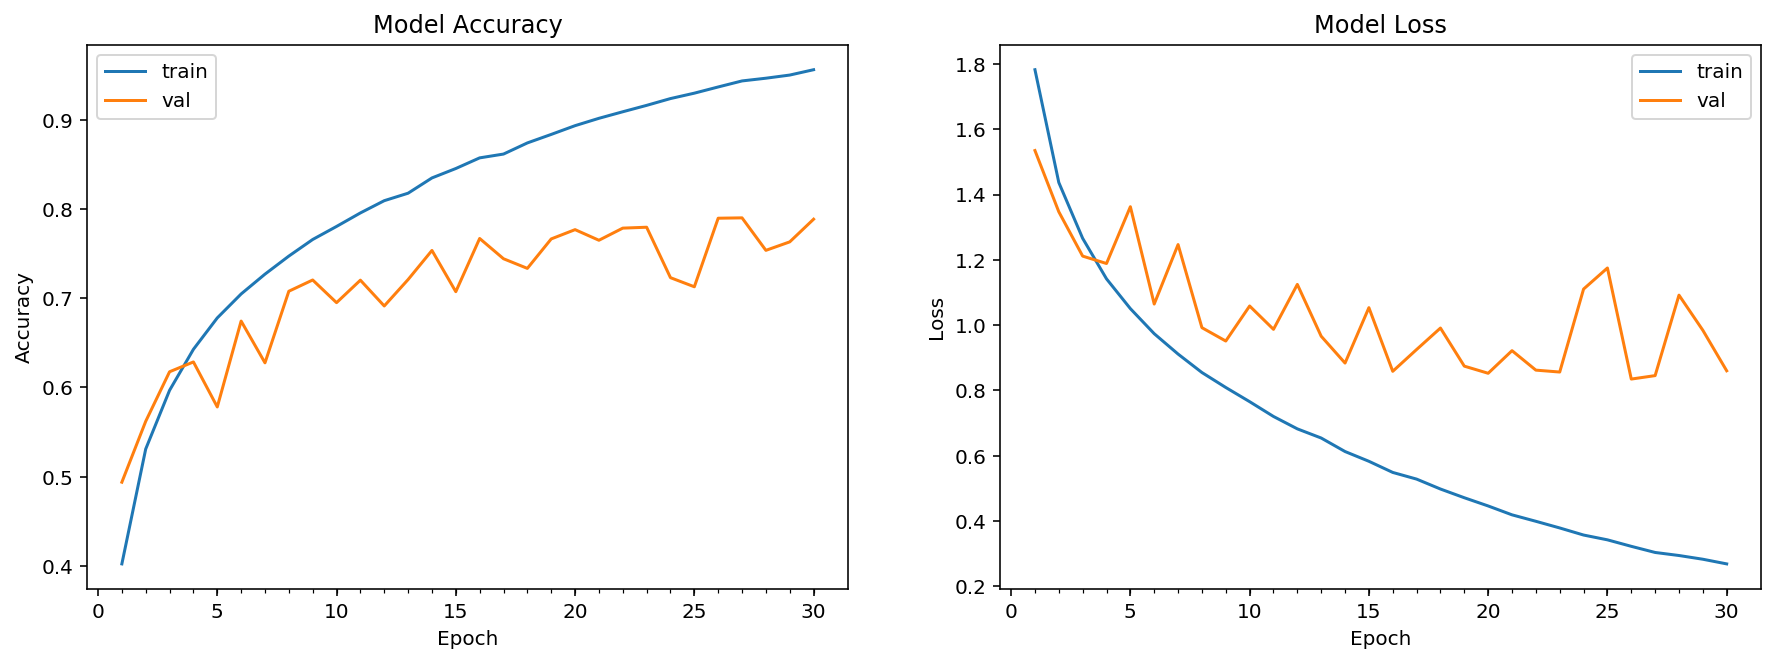

Accuracy on test data is: 78.84


In [13]:
inputs = Input(shape=(32,32,3))

x1 = depthwise_conv_layer(inputs, n_kernels=64,kernel_size=(5,5),border_mode='valid')

x2 = norm_conv_layer(x1,n_kernels=64,kernel_size=(5,5),border_mode='same')  # 9

x3 = norm_conv_layer(x2,n_kernels=64,kernel_size=(5,5),border_mode='same')  #13

x4 = concatenate([x1, x3]) # 9,17
x4 = depthwise_conv_layer(x4, n_kernels=64,kernel_size=(5,5),border_mode='same')

x5 = MaxPooling2D(pool_size=(2, 2),)(x4)
x5 = norm_conv_layer(x5,n_kernels=32,kernel_size=(1,1),border_mode='same')

x6 = depthwise_conv_layer(x5, n_kernels=128,kernel_size=(3,3),border_mode='same') 

x7_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x7_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x7 = concatenate([x6, x7_1, x7_2])
x7 = norm_conv_layer(x7, n_kernels=128,kernel_size=(5,5),border_mode='same')


x8_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x8_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x8 = concatenate([x6, x7,x8_1,x8_2])
x8 = depthwise_conv_layer(x8, n_kernels=128,kernel_size=(3,3),border_mode='same')


x9_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x9_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x9_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x9 = concatenate([x6,x7,x8,x9_1, x9_2,x9_3])
x9 = depthwise_conv_layer(x9, n_kernels=128,kernel_size=(5,5),border_mode='same')

x10_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x10 = concatenate([x6,x8,x9,x10_1])
x10 = MaxPooling2D(pool_size=(2, 2),)(x10)
x10 = norm_conv_layer(x10,n_kernels=32,kernel_size=(1,1),border_mode='same')

#x11_1 = norm_conv_layer(x10, n_kernels=64,kernel_size=(5,5),border_mode='same')
x11_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x7)
x11 = concatenate([x10, x11_1])
x11 = norm_conv_layer(x11, n_kernels=256,kernel_size=(5,5),border_mode='same')


x12_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x12_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x12_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x12 = concatenate([x11, x12_1, x12_2,x12_3])
x12 = depthwise_conv_layer(x12, n_kernels=256,kernel_size=(5,5),border_mode='same')


x13_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x13_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x13_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x13 = concatenate([x11,x12,x13_1, x13_2,x13_3])
x13 = norm_conv_layer(x13, n_kernels=256,kernel_size=(3,3),border_mode='same')

x14_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x14_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x14_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x1)
x14_4 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x14_5 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x14 = concatenate([x12,x13,x14_1, x14_2,x14_3, x14_4, x14_5])
x14 = depthwise_conv_layer(x14, n_kernels=256,kernel_size=(5,5),border_mode='same')

x15_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x15_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x15 = concatenate([x12,x14,x15_1, x15_2])
x15 = norm_conv_layer(x15,n_kernels=32,kernel_size=(1,1),border_mode='same')  # 9

output = output_layer(x15, n_classes=10, kernel_size=(7,7)) # 24, 32

model = Model(inputs=inputs, outputs=output)
optimizer = SGD(lr=0.01)
model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])


model.summary()

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 30, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

W0904 17:39:41.535131 140348486625152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 17:39:41.574585 140348486625152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), strides=1, kernel_regularizer=<keras.reg..., dilation_rate=1, depth_multiplier=1, padding="valid")`
  
W0904 17:39:41.585799 140348486625152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 17

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 28, 28, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

W0904 17:39:47.417324 140348486625152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
390/390 [==============================] - 222s 569ms/step - loss: 1.9039 - acc: 0.3588 - val_loss: 1.6461 - val_acc: 0.4542
Epoch 2/30
390/390 [==============================] - 210s 537ms/step - loss: 1.5759 - acc: 0.4784 - val_loss: 1.5701 - val_acc: 0.4897
Epoch 3/30
390/390 [==============================] - 210s 538ms/step - loss: 1.4336 - acc: 0.5348 - val_loss: 1.3732 - val_acc: 0.5590
Epoch 4/30
390/390 [==============================] - 210s 539ms/step - loss: 1.3230 - acc: 0.5745 - val_loss: 1.3326 - val_acc: 0.5753
Epoch 5/30
390/390 [==============================] - 209s 537ms/step - loss: 1.2250 - acc: 0.6140 - val_loss: 1.2326 - val_acc: 0.6079
Epoch 6/30
390/390 [==============================] - 209s 535ms/step - loss: 1.1527 - acc: 0.6426 - val_loss: 1.2177 - val_acc: 0.6167
Epoch 7/30
390/390 [==============================] - 209s 536ms/step - loss: 1.0865 - acc: 0.6642 - val_loss: 1.2165 - val_acc: 0.6208
Epoch 8/30
390/390 [============================

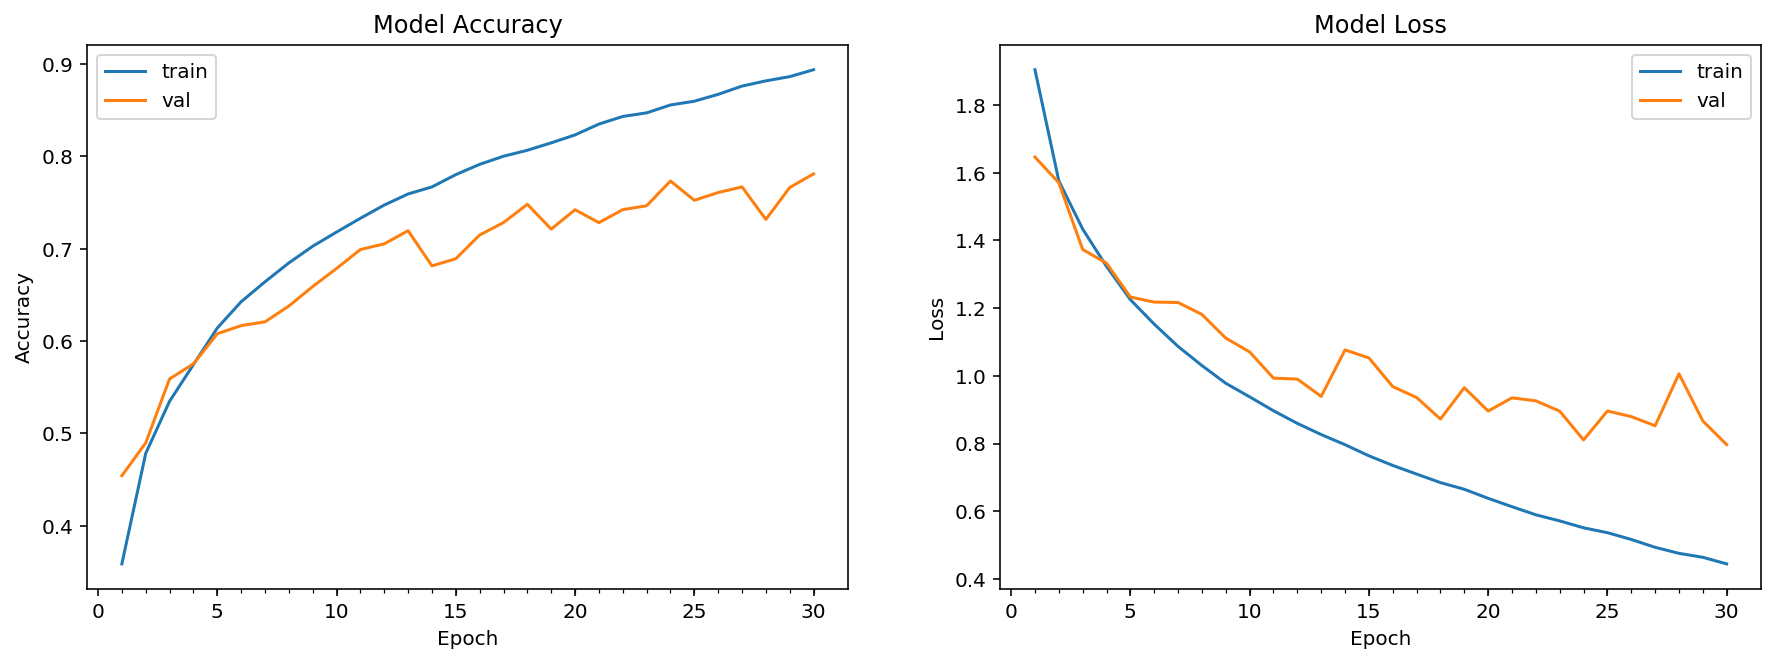

Accuracy on test data is: 78.10


In [11]:
inputs = Input(shape=(32,32,3))

x1 = depthwise_conv_layer(inputs, n_kernels=64,kernel_size=(5,5),border_mode='valid')

x2 = norm_conv_layer(x1,n_kernels=64,kernel_size=(5,5),border_mode='same')  # 9

x3 = norm_conv_layer(x2,n_kernels=64,kernel_size=(5,5),border_mode='same')  #13

x4 = concatenate([x1, x3]) # 9,17
x4 = depthwise_conv_layer(x4, n_kernels=64,kernel_size=(5,5),border_mode='same')

x5 = MaxPooling2D(pool_size=(2, 2),)(x4)
x5 = norm_conv_layer(x5,n_kernels=32,kernel_size=(1,1),border_mode='same')

x6 = depthwise_conv_layer(x5, n_kernels=128,kernel_size=(3,3),border_mode='same') 

x7_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x7_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x7 = concatenate([x6, x7_1, x7_2])
x7 = norm_conv_layer(x7, n_kernels=128,kernel_size=(5,5),border_mode='same')


x8_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x8_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x8 = concatenate([x6, x7,x8_1,x8_2])
x8 = depthwise_conv_layer(x8, n_kernels=128,kernel_size=(3,3),border_mode='same')


x9_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x1)
x9_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x3)
x9_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x9 = concatenate([x6,x7,x8,x9_1, x9_2,x9_3])
x9 = depthwise_conv_layer(x9, n_kernels=128,kernel_size=(5,5),border_mode='same')

x10_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x4)
x10 = concatenate([x6,x8,x9,x10_1])
x10 = MaxPooling2D(pool_size=(2, 2),)(x10)
x10 = norm_conv_layer(x10,n_kernels=32,kernel_size=(1,1),border_mode='same')

#x11_1 = norm_conv_layer(x10, n_kernels=64,kernel_size=(5,5),border_mode='same')
x11_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x7)
x11 = concatenate([x10, x11_1])
x11 = norm_conv_layer(x11, n_kernels=256,kernel_size=(5,5),border_mode='same')


x12_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x12_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x12_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x12 = concatenate([x11, x12_1, x12_2,x12_3])
x12 = depthwise_conv_layer(x12, n_kernels=256,kernel_size=(5,5),border_mode='same')


x13_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x13_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x13_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x13 = concatenate([x11,x12,x13_1, x13_2,x13_3])
x13 = norm_conv_layer(x13, n_kernels=256,kernel_size=(3,3),border_mode='same')

x14_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x6)
x14_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x14_3 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x1)
x14_4 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x2)
x14_5 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x14 = concatenate([x12,x13,x14_1, x14_2,x14_3, x14_4, x14_5])
x14 = depthwise_conv_layer(x14, n_kernels=256,kernel_size=(5,5),border_mode='same')

x15_1 = Lambda(lambda x:tf.space_to_depth(x, block_size=2))(x8)
x15_2 = Lambda(lambda x:tf.space_to_depth(x, block_size=4))(x4)
x15 = concatenate([x12,x14,x15_1, x15_2])
x15 = norm_conv_layer(x15,n_kernels=32,kernel_size=(1,1),border_mode='same')  # 9

output = output_layer(x15, n_classes=10, kernel_size=(7,7)) # 24, 32

model = Model(inputs=inputs, outputs=output)
optimizer = SGD(lr=0.005)
model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])


model.summary()

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 30, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Summary
========

The model trained with a validation accuracy of around 71.19%. The model graphs shows a lot of spike. One of the possible reason could be the optimization problem. 

This program is to demonstarte functional API . We will work much more on the functional API's in future and work towards making a perfect fit model.

**********   End of Program *************